In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
import torch
import torch.nn as nn
import numpy as np
import os
import json
from datetime import datetime

from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, classification_report

In [6]:
from utils import load_fold_paths, compute_metrics, cleanup, print_metrics, plot_confusion_matrix, print_cross_validation_results
from models.rnn import AudioRNN, LazyAudioRNNDataset, collate_fn_rnn
from models.helper_classes import TrainingHistory

In [7]:
METADATA_PATH = '../UrbanSound8K/metadata/UrbanSound8K.csv'
AUDIO_BASE_PATH = '../UrbanSound8K/audio'

In [8]:
def train_audio_rnn_cross_validation(data_cache_dir, config):
    """
        10-Fold Cross-Validation Pipeline for UrbanSound8K
        """
    epochs = config["epochs"]
    batch_size = config["batch_size"]
    lr = config["lr"]
    num_classes = config["num_classes"]

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        print(f"Initial GPU memory allocated: {torch.cuda.memory_allocated()/1024**2:.2f} MB")
    
    train_paths, train_labels, test_paths, test_labels = load_fold_paths(data_cache_dir=data_cache_dir)
    
    timestamp = datetime.now().strftime("%m%d_%H%M%S")
    save_dir = f"../saved_cv/{timestamp}"
    os.makedirs(save_dir, exist_ok=True)
    print(f"Save directory: {save_dir}")
    
    with open(os.path.join(save_dir, 'config.json'), 'w') as f:
        json.dump(config, f, indent=2)
    
    fold_results = []
    all_fold_accuracies = []
    cumulative_confusion_matrix = np.zeros((num_classes, num_classes), dtype=int)
    
    print("\n" + "="*60)
    print("10-FOLD CROSS-VALIDATION")
    print("="*60)
    print("Scheme: 1 fold test, 1 fold validation, 8 folds training")
    print("="*60)
    
    for test_fold in range(1, 11):
        val_fold = (test_fold % 10) + 1
        train_folds = [f for f in range(1, 11) if f != test_fold and f != val_fold]
        
        print(f"\n{'='*60}")
        print(f"FOLD {test_fold}/10")
        print(f"{'='*60}")
        print(f"Test fold: {test_fold}")
        print(f"Validation fold: {val_fold}")
        print(f"Training folds: {train_folds}")
        
        fold_dir = os.path.join(save_dir, f'fold_{test_fold}')
        os.makedirs(fold_dir, exist_ok=True)
        
        print("\n" + "="*60)
        print("STEP 1: Loading Data from Cache")
        print("="*60)

        X_train = sum((train_paths[f] for f in train_folds), [])
        y_train = sum((train_labels[f] for f in train_folds), [])

        X_val = test_paths[val_fold]
        y_val = test_labels[val_fold]

        X_test = test_paths[test_fold]
        y_test = test_labels[test_fold]

        train_dataset = LazyAudioRNNDataset(X_train, y_train)
        val_dataset   = LazyAudioRNNDataset(X_val, y_val)
        test_dataset  = LazyAudioRNNDataset(X_test, y_test)

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, collate_fn=collate_fn_rnn)
        val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False, num_workers=0, collate_fn=collate_fn_rnn)
        test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False, num_workers=0, collate_fn=collate_fn_rnn)
        
        print("\n" + "="*60)
        print("STEP 2: Creating Model")
        print("="*60)
        
        model = AudioRNN(num_classes=num_classes, config=config)
        model = model.to(device)
        
        total_params = sum(p.numel() for p in model.parameters())
        print(f"Total parameters: {total_params:,}")
        
        if torch.cuda.is_available():
            print(f"GPU memory after model creation: {torch.cuda.memory_allocated()/1024**2:.2f} MB")
        
        print("\n" + "="*60)
        print("STEP 3: Training Model")
        print("="*60)
        
        criterion = nn.NLLLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=lr,
                                    betas = (config.get('betas')[0],
                                    config.get('betas')[1]),
                                    eps = config.get('eps'),
                                    weight_decay=config.get('weight_decay'))

        history = TrainingHistory()
        
        best_val_loss, best_val_acc = AudioRNN.trainModel(
            model=model,
            train_loader=train_loader,
            val_loader=val_loader,
            test_fold=test_fold,
            history=history,
            config=config,
            fold_dir=fold_dir,
            epochs=epochs,
            optimizer=optimizer,
            criterion=criterion,
            device=device
        )
        
        print("\n" + "="*60)
        print("STEP 4: Testing on Held-Out Fold")
        print("="*60)
        
        checkpoint = torch.load(os.path.join(fold_dir, 'best_model.pth'))
        model.load_state_dict(checkpoint['model_state_dict'])
        
        model.eval()

        avg_test_loss, test_acc, all_predictions, all_targets = AudioRNN.test(model, criterion, test_loader, device)
        
        print(f"\nTest Loss: {avg_test_loss:.4f}")
        print(f"Test Accuracy: {test_acc:.4f}")
        
        test_metrics = compute_metrics(all_predictions, all_targets, num_classes)
        print_metrics(test_metrics, prefix="Test ")
        
        fold_confusion_matrix = confusion_matrix(all_targets, all_predictions, labels=range(num_classes))
        cumulative_confusion_matrix += fold_confusion_matrix
        
        fold_result = {
            'fold': test_fold,
            'test_fold': test_fold,
            'val_fold': val_fold,
            'train_folds': train_folds,
            'test_loss': avg_test_loss,
            'test_accuracy': test_metrics['accuracy'],
            'test_precision_macro': test_metrics['precision_macro'],
            'test_precision_weighted': test_metrics['precision_weighted'],
            'test_recall_macro': test_metrics['recall_macro'],
            'test_recall_weighted': test_metrics['recall_weighted'],
            'test_f1_macro': test_metrics['f1_macro'],
            'test_f1_weighted': test_metrics['f1_weighted'],
            'test_precision_per_class': test_metrics['precision_per_class'],
            'test_recall_per_class': test_metrics['recall_per_class'],
            'test_f1_per_class': test_metrics['f1_per_class'],
            'best_val_accuracy': best_val_acc,
            'best_val_loss': best_val_loss,
            'confusion_matrix': fold_confusion_matrix.tolist()
        }
        fold_results.append(fold_result)
        all_fold_accuracies.append(test_acc)
        
        with open(os.path.join(fold_dir, 'fold_results.json'), 'w') as f:
            json.dump(fold_result, f, indent=2)
        
        class_names = [f'Class_{i}' for i in range(num_classes)]
        report = classification_report(all_targets, all_predictions, 
                                      target_names=class_names, 
                                      digits=4)
        with open(os.path.join(fold_dir, 'classification_report.txt'), 'w') as f:
            f.write(f"Classification Report - Fold {test_fold}\n")
            f.write("="*60 + "\n")
            f.write(report)
        
        history.save(os.path.join(fold_dir, 'history.json'))
        history.plot(save_path=os.path.join(fold_dir, 'training_curves.png'))
        
        plot_confusion_matrix(
            fold_confusion_matrix,
            save_path=os.path.join(fold_dir, 'confusion_matrix.png'),
            title=f'Confusion Matrix - Fold {test_fold}'
        )
        
        print(f"\nFold {test_fold} completed!")
        print(f"Results saved to: {fold_dir}")
        
        cleanup(train_loader, val_loader, test_loader,
            train_dataset, val_dataset, test_dataset,
            model, optimizer, criterion, history,
            all_predictions, all_targets,
            checkpoint)

    print("\n" + "="*60)
    print("CROSS-VALIDATION RESULTS")
    print("="*60)

    return print_cross_validation_results(fold_results, save_dir, cumulative_confusion_matrix, all_fold_accuracies, config)


In [9]:
import os
from datetime import datetime

from utils import read_config

config = read_config("../config/cnn.json")

base_dir = '../data_cache'
folders = [f for f in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, f))]

folder_dates = []
for folder in folders:
    try:
        folder_date = datetime.strptime(folder, '%m%d_%H%M%S')
        folder_dates.append((folder_date, folder))
    except ValueError:
        print(f"Folder name '{folder}' does not match expected format.")

if folder_dates:
    most_recent_folder = max(folder_dates, key=lambda x: x[0])[1]
    data_cache_dir = os.path.join(base_dir, most_recent_folder)
    print(f"Most recent folder: {data_cache_dir}")

else:
    print("No valid folders found.")

Most recent folder: ../data_cache/1128_230416


Using device: cuda
Initial GPU memory allocated: 35.93 MB
Save directory: ../saved_cv/1130_003048

10-FOLD CROSS-VALIDATION
Scheme: 1 fold test, 1 fold validation, 8 folds training

FOLD 1/10
Test fold: 1
Validation fold: 2
Training folds: [3, 4, 5, 6, 7, 8, 9, 10]

STEP 1: Loading Data from Cache

STEP 2: Creating Model
Total parameters: 83,722
GPU memory after model creation: 36.77 MB

STEP 3: Training Model

Epoch 1/20
----------------------------------------


Train Loss: 1.6161, Train Acc: 0.4557
Val Loss: 2.0299, Val Acc: 0.4065

Epoch 2/20
----------------------------------------


Train Loss: 1.1759, Train Acc: 0.6185
Val Loss: 2.3930, Val Acc: 0.3682

Epoch 3/20
----------------------------------------


Train Loss: 1.0468, Train Acc: 0.6680
Val Loss: 2.4105, Val Acc: 0.3514

Epoch 4/20
----------------------------------------


Train Loss: 1.0346, Train Acc: 0.6755
Val Loss: 1.9879, Val Acc: 0.4167

Epoch 5/20
----------------------------------------


Train Loss: 0.9385, Train Acc: 0.7029
Val Loss: 2.1777, Val Acc: 0.4178

Epoch 6/20
----------------------------------------


Train Loss: 0.8715, Train Acc: 0.7334
Val Loss: 1.9546, Val Acc: 0.4347

Epoch 7/20
----------------------------------------


Train Loss: 0.7782, Train Acc: 0.7595
Val Loss: 1.9519, Val Acc: 0.4358

Epoch 8/20
----------------------------------------


Train Loss: 0.8016, Train Acc: 0.7516
Val Loss: 2.2163, Val Acc: 0.3750

Epoch 9/20
----------------------------------------


Train Loss: 1.0935, Train Acc: 0.6375
Val Loss: 2.1327, Val Acc: 0.3975

Epoch 10/20
----------------------------------------


Train Loss: 1.0063, Train Acc: 0.6702
Val Loss: 2.2245, Val Acc: 0.4144

Epoch 11/20
----------------------------------------


Train Loss: 0.9562, Train Acc: 0.6857
Val Loss: 2.2598, Val Acc: 0.4268

Epoch 12/20
----------------------------------------


Train Loss: 0.9298, Train Acc: 0.6930
Val Loss: 2.2862, Val Acc: 0.4245

Epoch 13/20
----------------------------------------


Train Loss: 0.9069, Train Acc: 0.7064
Val Loss: 2.3252, Val Acc: 0.4291

Epoch 14/20
----------------------------------------


Train Loss: 0.8788, Train Acc: 0.7131
Val Loss: 2.3316, Val Acc: 0.4369

Epoch 15/20
----------------------------------------


Train Loss: 0.8624, Train Acc: 0.7232
Val Loss: 2.3884, Val Acc: 0.4347

Epoch 16/20
----------------------------------------


Train Loss: 0.8339, Train Acc: 0.7353
Val Loss: 2.3728, Val Acc: 0.4392

Epoch 17/20
----------------------------------------


Train Loss: 0.8240, Train Acc: 0.7317
Val Loss: 2.3768, Val Acc: 0.4459

Epoch 18/20
----------------------------------------


Train Loss: 0.8009, Train Acc: 0.7441
Val Loss: 2.3919, Val Acc: 0.4426

Epoch 19/20
----------------------------------------


Train Loss: 0.7903, Train Acc: 0.7468
Val Loss: 2.3998, Val Acc: 0.4381

Epoch 20/20
----------------------------------------


Train Loss: 0.7710, Train Acc: 0.7519
Val Loss: 2.3848, Val Acc: 0.4448

STEP 4: Testing on Held-Out Fold


Testing: 100%|██████████| 55/55 [00:00<00:00, 109.47it/s, loss=0.8156]



Test Loss: 1.7383
Test Accuracy: 0.4742

Test Metrics:
  Accuracy:          0.4742
  Precision (macro): 0.4974
  Recall (macro):    0.5152
  F1-Score (macro):  0.4930
  Precision (wtd):   0.4893
  Recall (wtd):      0.4742
  F1-Score (wtd):    0.4702


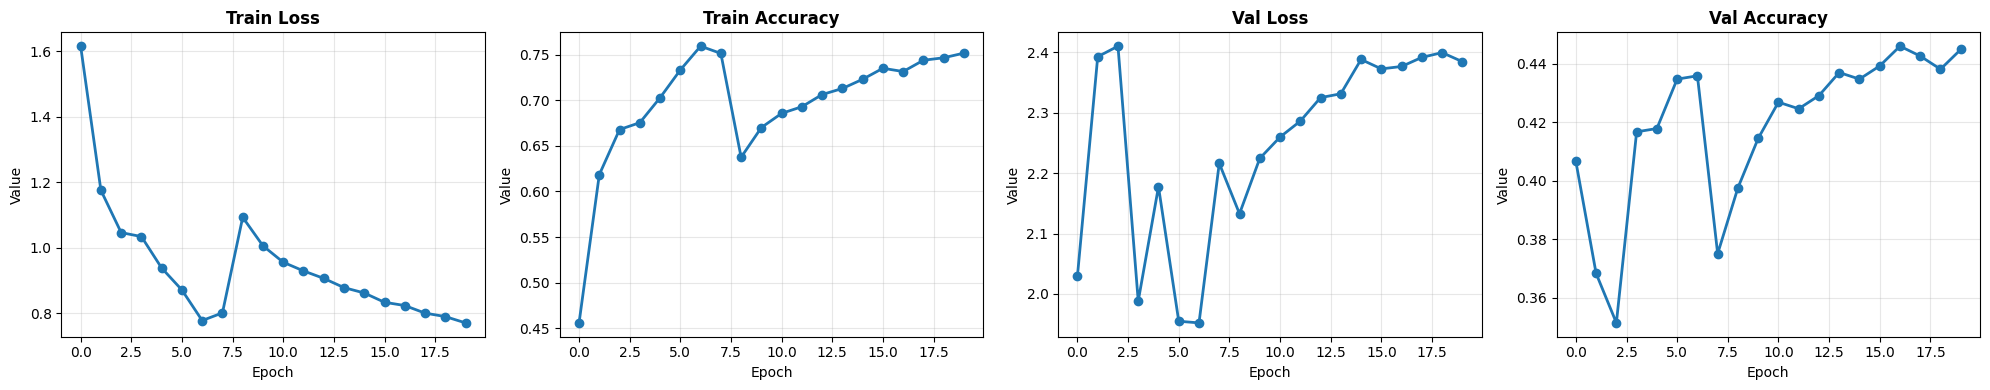

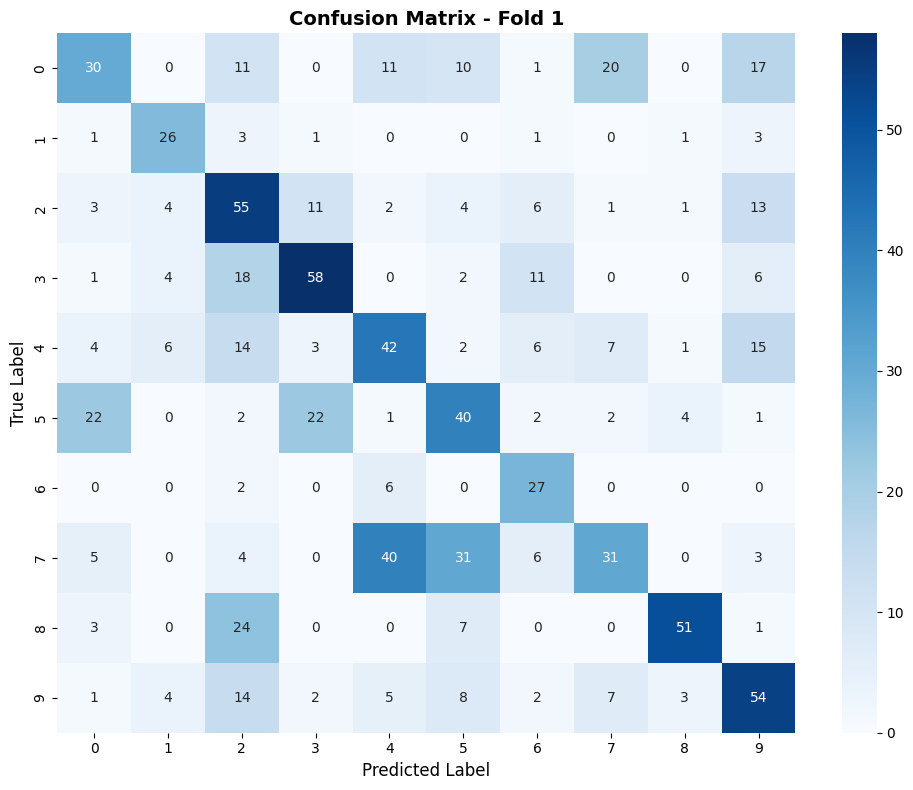


Fold 1 completed!
Results saved to: ../saved_cv/1130_003048/fold_1

FOLD 2/10
Test fold: 2
Validation fold: 3
Training folds: [1, 4, 5, 6, 7, 8, 9, 10]

STEP 1: Loading Data from Cache

STEP 2: Creating Model
Total parameters: 83,722
GPU memory after model creation: 39.54 MB

STEP 3: Training Model

Epoch 1/20
----------------------------------------


Train Loss: 1.5915, Train Acc: 0.4633
Val Loss: 2.0634, Val Acc: 0.4032

Epoch 2/20
----------------------------------------


Train Loss: 1.2028, Train Acc: 0.6128
Val Loss: 2.1574, Val Acc: 0.4022

Epoch 3/20
----------------------------------------


Train Loss: 1.0599, Train Acc: 0.6654
Val Loss: 2.0936, Val Acc: 0.4400

Epoch 4/20
----------------------------------------


Train Loss: 1.0870, Train Acc: 0.6616
Val Loss: 2.2076, Val Acc: 0.4324

Epoch 5/20
----------------------------------------


Train Loss: 1.1534, Train Acc: 0.6397
Val Loss: 2.0921, Val Acc: 0.4119

Epoch 6/20
----------------------------------------


Train Loss: 0.9580, Train Acc: 0.7077
Val Loss: 2.0704, Val Acc: 0.4854

Epoch 7/20
----------------------------------------


Train Loss: 0.8444, Train Acc: 0.7409
Val Loss: 2.1993, Val Acc: 0.4519

Epoch 8/20
----------------------------------------


Train Loss: 0.9279, Train Acc: 0.7000
Val Loss: 2.1924, Val Acc: 0.4584

Epoch 9/20
----------------------------------------


Train Loss: 0.8418, Train Acc: 0.7295
Val Loss: 2.3594, Val Acc: 0.4638

Epoch 10/20
----------------------------------------


Train Loss: 0.7980, Train Acc: 0.7496
Val Loss: 2.3165, Val Acc: 0.4562

Epoch 11/20
----------------------------------------


Train Loss: 0.7239, Train Acc: 0.7706
Val Loss: 2.2763, Val Acc: 0.4703

Epoch 12/20
----------------------------------------


Train Loss: 0.6763, Train Acc: 0.7901
Val Loss: 2.3324, Val Acc: 0.4638

Epoch 13/20
----------------------------------------


Train Loss: 0.6683, Train Acc: 0.7885
Val Loss: 2.4206, Val Acc: 0.4724

Epoch 14/20
----------------------------------------


Train Loss: 0.6543, Train Acc: 0.7977
Val Loss: 2.5504, Val Acc: 0.4443

Epoch 15/20
----------------------------------------


Train Loss: 0.6257, Train Acc: 0.8055
Val Loss: 2.4801, Val Acc: 0.4681

Epoch 16/20
----------------------------------------


Train Loss: 0.5826, Train Acc: 0.8197
Val Loss: 2.6382, Val Acc: 0.4551

Epoch 17/20
----------------------------------------


Train Loss: 0.5655, Train Acc: 0.8331
Val Loss: 2.6670, Val Acc: 0.4584

Epoch 18/20
----------------------------------------


Train Loss: 0.5796, Train Acc: 0.8250
Val Loss: 2.7143, Val Acc: 0.4443

Epoch 19/20
----------------------------------------


Train Loss: 0.5600, Train Acc: 0.8276
Val Loss: 2.5289, Val Acc: 0.4789

Epoch 20/20
----------------------------------------


Train Loss: 0.5435, Train Acc: 0.8339
Val Loss: 2.5811, Val Acc: 0.4659

STEP 4: Testing on Held-Out Fold


Testing: 100%|██████████| 56/56 [00:00<00:00, 109.23it/s, loss=1.2631]



Test Loss: 2.0234
Test Accuracy: 0.3705

Test Metrics:
  Accuracy:          0.3705
  Precision (macro): 0.4046
  Recall (macro):    0.4244
  F1-Score (macro):  0.3842
  Precision (wtd):   0.3867
  Recall (wtd):      0.3705
  F1-Score (wtd):    0.3476


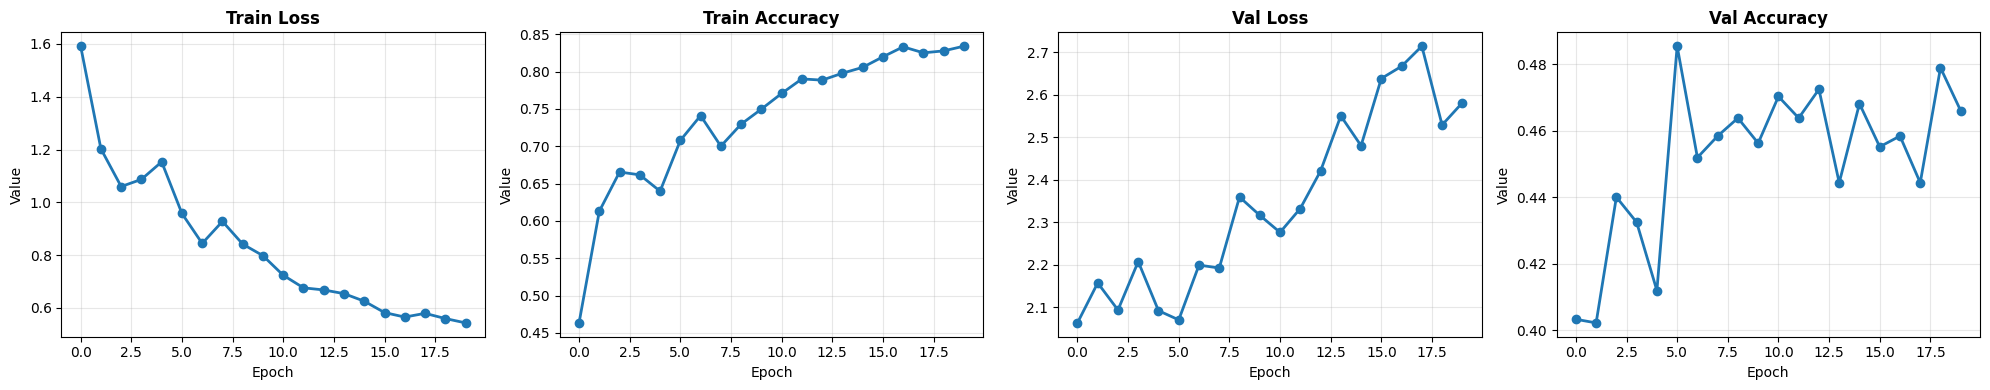

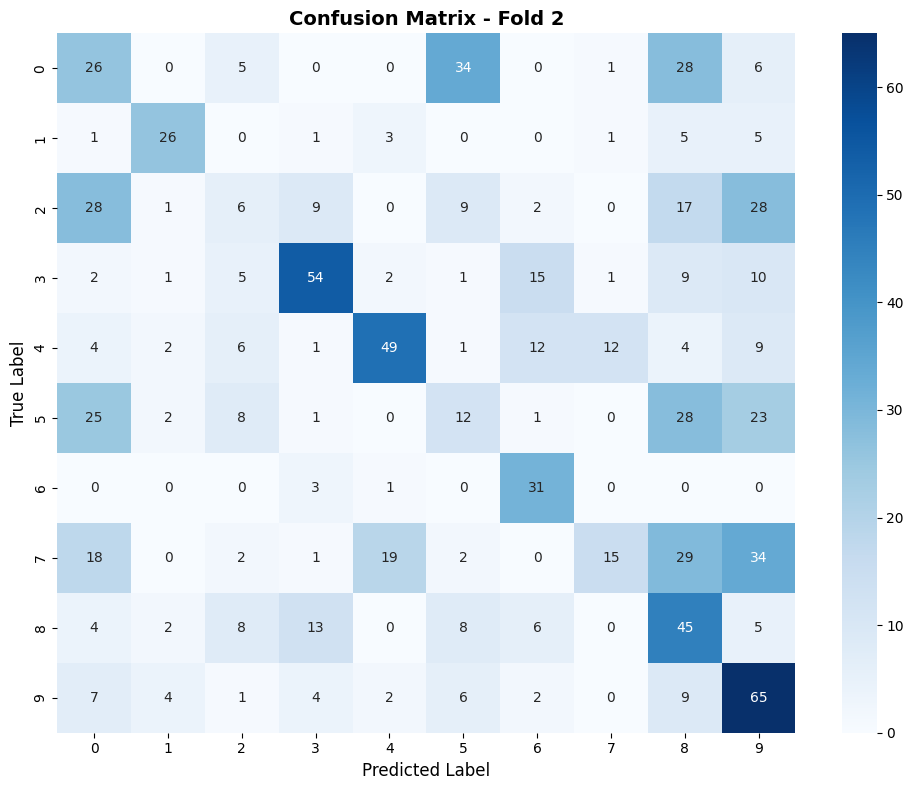


Fold 2 completed!
Results saved to: ../saved_cv/1130_003048/fold_2

FOLD 3/10
Test fold: 3
Validation fold: 4
Training folds: [1, 2, 5, 6, 7, 8, 9, 10]

STEP 1: Loading Data from Cache

STEP 2: Creating Model
Total parameters: 83,722
GPU memory after model creation: 39.54 MB

STEP 3: Training Model

Epoch 1/20
----------------------------------------


Train Loss: 1.5744, Train Acc: 0.4654
Val Loss: 1.8111, Val Acc: 0.4222

Epoch 2/20
----------------------------------------


Train Loss: 1.1370, Train Acc: 0.6396
Val Loss: 2.0407, Val Acc: 0.4101

Epoch 3/20
----------------------------------------


Train Loss: 1.0133, Train Acc: 0.6757
Val Loss: 1.9976, Val Acc: 0.4313

Epoch 4/20
----------------------------------------


Train Loss: 0.9977, Train Acc: 0.6923
Val Loss: 2.3049, Val Acc: 0.4212

Epoch 5/20
----------------------------------------


Train Loss: 0.9379, Train Acc: 0.7025
Val Loss: 1.9508, Val Acc: 0.5131

Epoch 6/20
----------------------------------------


Train Loss: 0.7280, Train Acc: 0.7726
Val Loss: 2.1280, Val Acc: 0.4646

Epoch 7/20
----------------------------------------


Train Loss: 0.6696, Train Acc: 0.7900
Val Loss: 2.1893, Val Acc: 0.4788

Epoch 8/20
----------------------------------------


Train Loss: 0.7200, Train Acc: 0.7765
Val Loss: 2.2675, Val Acc: 0.4141

Epoch 9/20
----------------------------------------


Train Loss: 0.6663, Train Acc: 0.7956
Val Loss: 2.2678, Val Acc: 0.4444

Epoch 10/20
----------------------------------------


Train Loss: 0.5916, Train Acc: 0.8102
Val Loss: 2.2281, Val Acc: 0.4848

Epoch 11/20
----------------------------------------


Train Loss: 0.5021, Train Acc: 0.8417
Val Loss: 2.3079, Val Acc: 0.4818

Epoch 12/20
----------------------------------------


Train Loss: 0.4775, Train Acc: 0.8537
Val Loss: 2.3683, Val Acc: 0.5030

Epoch 13/20
----------------------------------------


Train Loss: 0.4638, Train Acc: 0.8556
Val Loss: 2.4637, Val Acc: 0.4818

Epoch 14/20
----------------------------------------


Train Loss: 0.5380, Train Acc: 0.8345
Val Loss: 2.3916, Val Acc: 0.4626

Epoch 15/20
----------------------------------------


Train Loss: 0.4744, Train Acc: 0.8495
Val Loss: 2.4658, Val Acc: 0.4747

Epoch 16/20
----------------------------------------


Train Loss: 0.4318, Train Acc: 0.8651
Val Loss: 2.4761, Val Acc: 0.4778

Epoch 17/20
----------------------------------------


Train Loss: 0.4145, Train Acc: 0.8688
Val Loss: 2.4609, Val Acc: 0.4970

Epoch 18/20
----------------------------------------


Train Loss: 0.4084, Train Acc: 0.8727
Val Loss: 2.4045, Val Acc: 0.5111

Epoch 19/20
----------------------------------------


Train Loss: 0.3854, Train Acc: 0.8834
Val Loss: 2.5425, Val Acc: 0.5101

Epoch 20/20
----------------------------------------


Train Loss: 0.3779, Train Acc: 0.8867
Val Loss: 2.5652, Val Acc: 0.5071

STEP 4: Testing on Held-Out Fold


Testing: 100%|██████████| 58/58 [00:00<00:00, 122.67it/s, loss=1.9093]



Test Loss: 2.1397
Test Accuracy: 0.3805

Test Metrics:
  Accuracy:          0.3805
  Precision (macro): 0.3865
  Recall (macro):    0.4227
  F1-Score (macro):  0.3821
  Precision (wtd):   0.3774
  Recall (wtd):      0.3805
  F1-Score (wtd):    0.3621


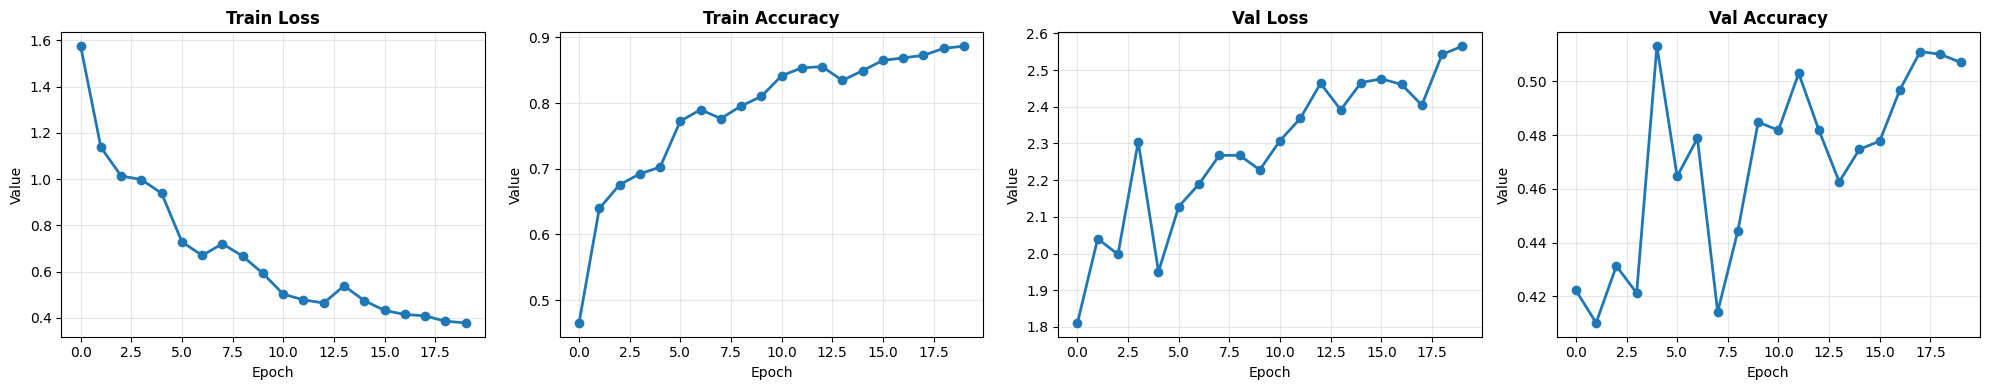

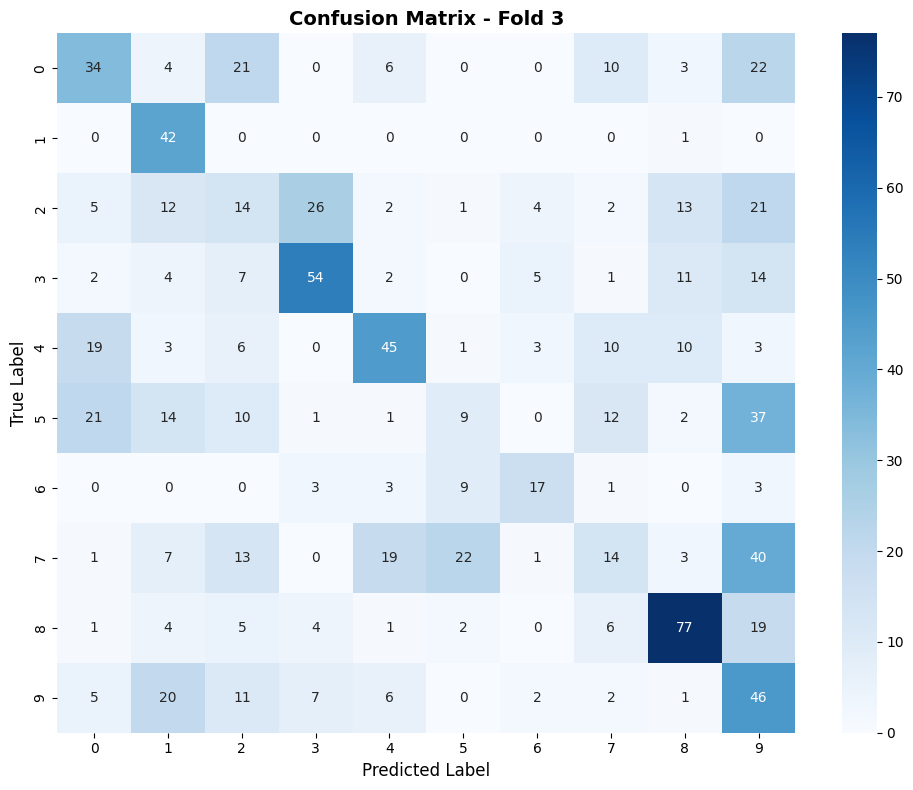


Fold 3 completed!
Results saved to: ../saved_cv/1130_003048/fold_3

FOLD 4/10
Test fold: 4
Validation fold: 5
Training folds: [1, 2, 3, 6, 7, 8, 9, 10]

STEP 1: Loading Data from Cache

STEP 2: Creating Model
Total parameters: 83,722
GPU memory after model creation: 39.54 MB

STEP 3: Training Model

Epoch 1/20
----------------------------------------


Train Loss: 1.5933, Train Acc: 0.4652
Val Loss: 1.8269, Val Acc: 0.4252

Epoch 2/20
----------------------------------------


Train Loss: 1.1627, Train Acc: 0.6227
Val Loss: 1.6540, Val Acc: 0.5118

Epoch 3/20
----------------------------------------


Train Loss: 0.9958, Train Acc: 0.6826
Val Loss: 1.5968, Val Acc: 0.5630

Epoch 4/20
----------------------------------------


Train Loss: 0.9288, Train Acc: 0.7089
Val Loss: 1.6637, Val Acc: 0.5673

Epoch 5/20
----------------------------------------


Train Loss: 0.8712, Train Acc: 0.7242
Val Loss: 1.7815, Val Acc: 0.5214

Epoch 6/20
----------------------------------------


Train Loss: 0.7482, Train Acc: 0.7658
Val Loss: 1.7948, Val Acc: 0.5609

Epoch 7/20
----------------------------------------


Train Loss: 0.6349, Train Acc: 0.8006
Val Loss: 1.8555, Val Acc: 0.5609

Epoch 8/20
----------------------------------------


Train Loss: 0.5768, Train Acc: 0.8157
Val Loss: 2.0061, Val Acc: 0.5470

Epoch 9/20
----------------------------------------


Train Loss: 0.5566, Train Acc: 0.8275
Val Loss: 1.8715, Val Acc: 0.5588

Epoch 10/20
----------------------------------------


Train Loss: 0.5287, Train Acc: 0.8356
Val Loss: 1.9609, Val Acc: 0.5865

Epoch 11/20
----------------------------------------


Train Loss: 0.4582, Train Acc: 0.8614
Val Loss: 2.0416, Val Acc: 0.5876

Epoch 12/20
----------------------------------------


Train Loss: 0.4239, Train Acc: 0.8715
Val Loss: 2.0062, Val Acc: 0.5769

Epoch 13/20
----------------------------------------


Train Loss: 0.4102, Train Acc: 0.8767
Val Loss: 2.0909, Val Acc: 0.5769

Epoch 14/20
----------------------------------------


Train Loss: 0.3918, Train Acc: 0.8808
Val Loss: 2.1112, Val Acc: 0.5748

Epoch 15/20
----------------------------------------


Train Loss: 0.3731, Train Acc: 0.8879
Val Loss: 2.1011, Val Acc: 0.5812

Epoch 16/20
----------------------------------------


Train Loss: 0.3359, Train Acc: 0.8968
Val Loss: 2.1396, Val Acc: 0.5844

Epoch 17/20
----------------------------------------


Train Loss: 0.3197, Train Acc: 0.9060
Val Loss: 2.0757, Val Acc: 0.5865

Epoch 18/20
----------------------------------------


Train Loss: 0.3124, Train Acc: 0.9073
Val Loss: 2.2166, Val Acc: 0.5855

Epoch 19/20
----------------------------------------


Train Loss: 0.3052, Train Acc: 0.9089
Val Loss: 2.5518, Val Acc: 0.5620

Epoch 20/20
----------------------------------------


Train Loss: 0.3032, Train Acc: 0.9107
Val Loss: 2.2140, Val Acc: 0.5929

STEP 4: Testing on Held-Out Fold


Testing: 100%|██████████| 62/62 [00:00<00:00, 123.83it/s, loss=2.6874]



Test Loss: 1.7602
Test Accuracy: 0.5263

Test Metrics:
  Accuracy:          0.5263
  Precision (macro): 0.5227
  Recall (macro):    0.5353
  F1-Score (macro):  0.5127
  Precision (wtd):   0.5386
  Recall (wtd):      0.5263
  F1-Score (wtd):    0.5199


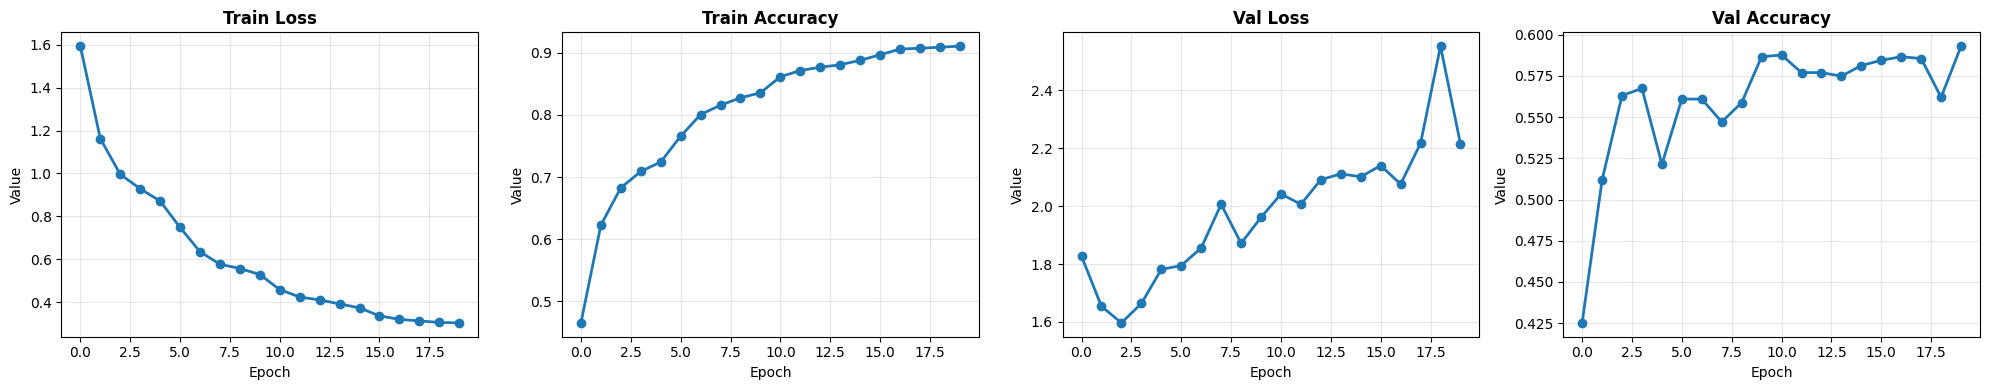

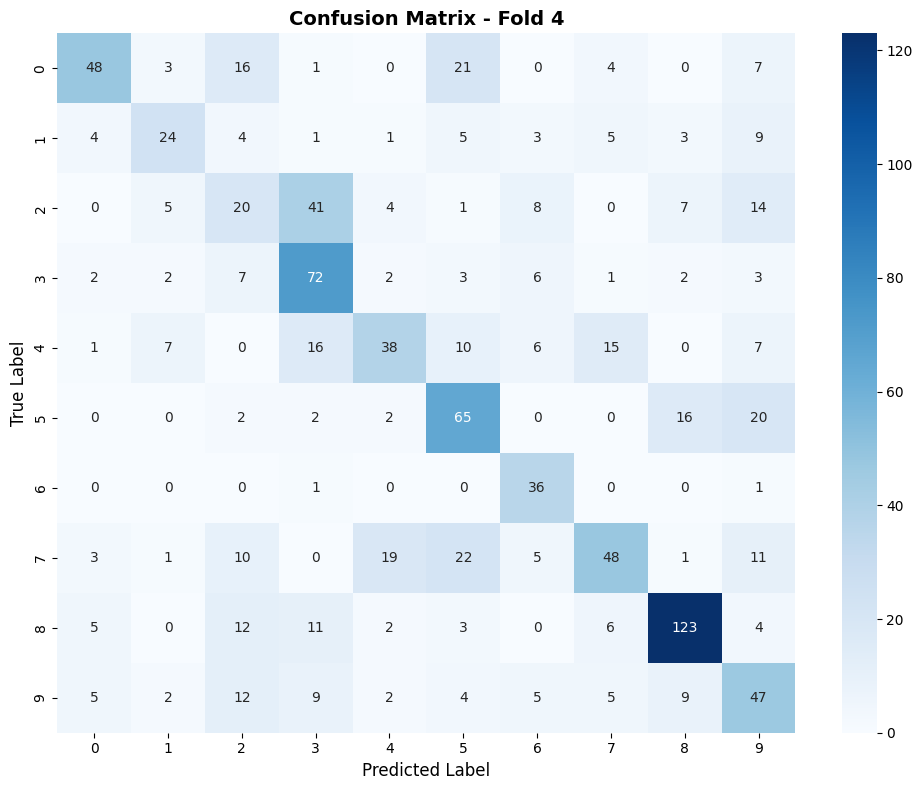


Fold 4 completed!
Results saved to: ../saved_cv/1130_003048/fold_4

FOLD 5/10
Test fold: 5
Validation fold: 6
Training folds: [1, 2, 3, 4, 7, 8, 9, 10]

STEP 1: Loading Data from Cache

STEP 2: Creating Model
Total parameters: 83,722
GPU memory after model creation: 39.54 MB

STEP 3: Training Model

Epoch 1/20
----------------------------------------


Train Loss: 1.5781, Train Acc: 0.4746
Val Loss: 2.0355, Val Acc: 0.3609

Epoch 2/20
----------------------------------------


Train Loss: 1.2085, Train Acc: 0.6122
Val Loss: 1.9695, Val Acc: 0.4447

Epoch 3/20
----------------------------------------


Train Loss: 1.0335, Train Acc: 0.6718
Val Loss: 2.1567, Val Acc: 0.4253

Epoch 4/20
----------------------------------------


Train Loss: 0.9541, Train Acc: 0.7004
Val Loss: 2.0931, Val Acc: 0.4301

Epoch 5/20
----------------------------------------


Train Loss: 0.8551, Train Acc: 0.7300
Val Loss: 2.2960, Val Acc: 0.4423

Epoch 6/20
----------------------------------------


Train Loss: 0.7369, Train Acc: 0.7712
Val Loss: 2.1719, Val Acc: 0.4800

Epoch 7/20
----------------------------------------


Train Loss: 0.6614, Train Acc: 0.7962
Val Loss: 2.1573, Val Acc: 0.4727

Epoch 8/20
----------------------------------------


Train Loss: 0.7023, Train Acc: 0.7894
Val Loss: 2.1421, Val Acc: 0.4848

Epoch 9/20
----------------------------------------


Train Loss: 0.6325, Train Acc: 0.8075
Val Loss: 2.4349, Val Acc: 0.4313

Epoch 10/20
----------------------------------------


Train Loss: 0.5883, Train Acc: 0.8191
Val Loss: 2.3457, Val Acc: 0.4642

Epoch 11/20
----------------------------------------


Train Loss: 0.5298, Train Acc: 0.8330
Val Loss: 2.3926, Val Acc: 0.4557

Epoch 12/20
----------------------------------------


Train Loss: 0.4884, Train Acc: 0.8476
Val Loss: 2.4132, Val Acc: 0.4727

Epoch 13/20
----------------------------------------


Train Loss: 0.4713, Train Acc: 0.8559
Val Loss: 2.4667, Val Acc: 0.4909

Epoch 14/20
----------------------------------------


Train Loss: 0.4677, Train Acc: 0.8557
Val Loss: 2.3545, Val Acc: 0.4933

Epoch 15/20
----------------------------------------


Train Loss: 0.4304, Train Acc: 0.8663
Val Loss: 2.5733, Val Acc: 0.4751

Epoch 16/20
----------------------------------------


Train Loss: 0.4032, Train Acc: 0.8734
Val Loss: 2.4888, Val Acc: 0.4957

Epoch 17/20
----------------------------------------


Train Loss: 0.3749, Train Acc: 0.8850
Val Loss: 2.4711, Val Acc: 0.4970

Epoch 18/20
----------------------------------------


Train Loss: 0.3641, Train Acc: 0.8908
Val Loss: 2.5149, Val Acc: 0.4982

Epoch 19/20
----------------------------------------


Train Loss: 0.3622, Train Acc: 0.8883
Val Loss: 2.5501, Val Acc: 0.4921

Epoch 20/20
----------------------------------------


Train Loss: 0.3503, Train Acc: 0.8921
Val Loss: 2.6329, Val Acc: 0.4957

STEP 4: Testing on Held-Out Fold


Testing: 100%|██████████| 59/59 [00:00<00:00, 124.44it/s, loss=0.3505]



Test Loss: 1.6285
Test Accuracy: 0.5256

Test Metrics:
  Accuracy:          0.5256
  Precision (macro): 0.5163
  Recall (macro):    0.5499
  F1-Score (macro):  0.5217
  Precision (wtd):   0.5111
  Recall (wtd):      0.5256
  F1-Score (wtd):    0.5084


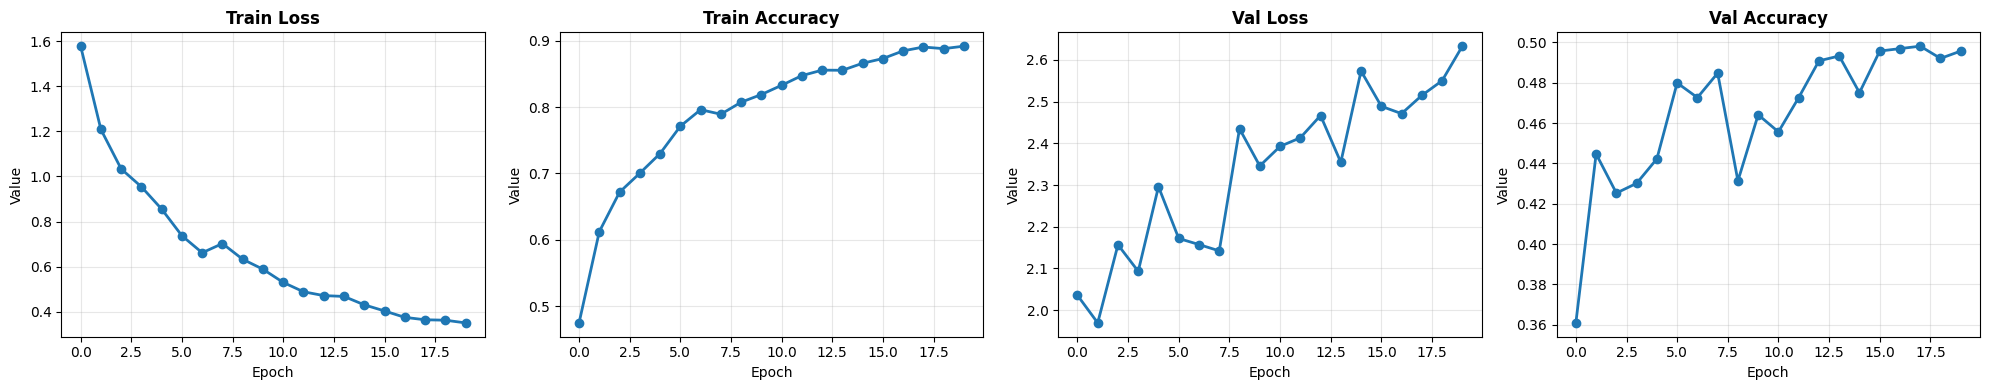

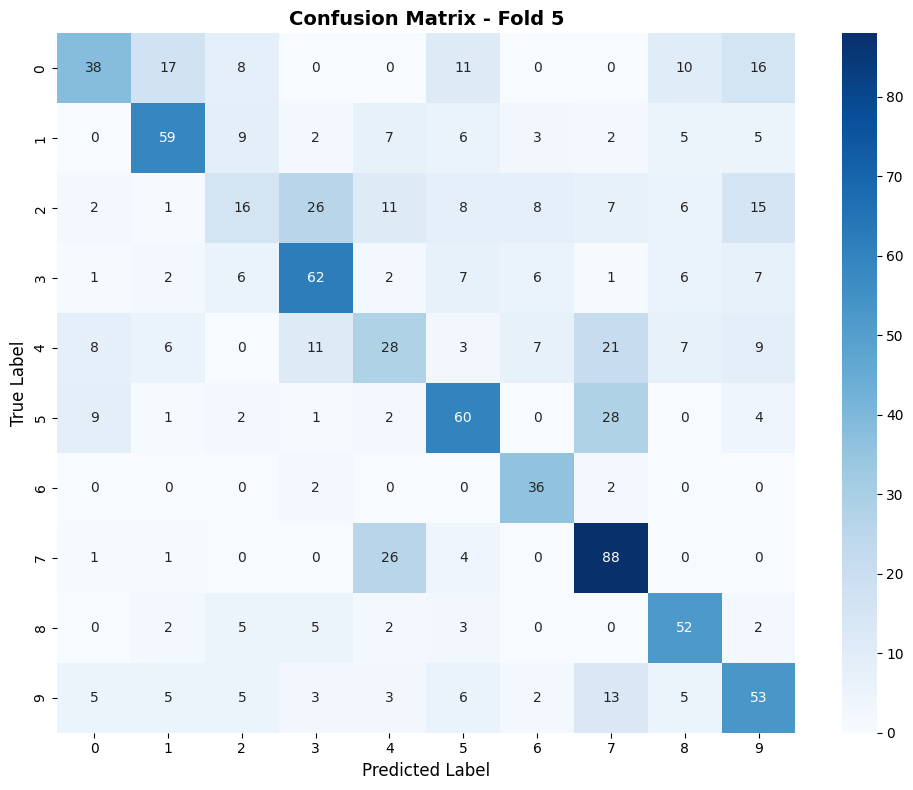


Fold 5 completed!
Results saved to: ../saved_cv/1130_003048/fold_5

FOLD 6/10
Test fold: 6
Validation fold: 7
Training folds: [1, 2, 3, 4, 5, 8, 9, 10]

STEP 1: Loading Data from Cache

STEP 2: Creating Model
Total parameters: 83,722
GPU memory after model creation: 39.54 MB

STEP 3: Training Model

Epoch 1/20
----------------------------------------


Train Loss: 1.5750, Train Acc: 0.4727
Val Loss: 1.9530, Val Acc: 0.3926

Epoch 2/20
----------------------------------------


Train Loss: 1.2146, Train Acc: 0.6042
Val Loss: 1.6504, Val Acc: 0.4952

Epoch 3/20
----------------------------------------


Train Loss: 1.0475, Train Acc: 0.6674
Val Loss: 1.8377, Val Acc: 0.4368

Epoch 4/20
----------------------------------------


Train Loss: 1.1245, Train Acc: 0.6459
Val Loss: 1.6997, Val Acc: 0.4761

Epoch 5/20
----------------------------------------


Train Loss: 0.9855, Train Acc: 0.6835
Val Loss: 1.6943, Val Acc: 0.5179

Epoch 6/20
----------------------------------------


Train Loss: 0.8430, Train Acc: 0.7388
Val Loss: 1.7982, Val Acc: 0.5155

Epoch 7/20
----------------------------------------


Train Loss: 0.7484, Train Acc: 0.7672
Val Loss: 1.8072, Val Acc: 0.5095

Epoch 8/20
----------------------------------------


Train Loss: 0.7279, Train Acc: 0.7768
Val Loss: 1.7011, Val Acc: 0.5609

Epoch 9/20
----------------------------------------


Train Loss: 0.6937, Train Acc: 0.7846
Val Loss: 1.7010, Val Acc: 0.5442

Epoch 10/20
----------------------------------------


Train Loss: 0.7080, Train Acc: 0.7722
Val Loss: 1.7985, Val Acc: 0.5167

Epoch 11/20
----------------------------------------


Train Loss: 0.5938, Train Acc: 0.8091
Val Loss: 1.7775, Val Acc: 0.5501

Epoch 12/20
----------------------------------------


Train Loss: 0.5708, Train Acc: 0.8208
Val Loss: 1.8226, Val Acc: 0.5370

Epoch 13/20
----------------------------------------


Train Loss: 0.5426, Train Acc: 0.8295
Val Loss: 1.8071, Val Acc: 0.5406

Epoch 14/20
----------------------------------------


Train Loss: 0.5016, Train Acc: 0.8456
Val Loss: 1.7846, Val Acc: 0.5585

Epoch 15/20
----------------------------------------


Train Loss: 0.4858, Train Acc: 0.8481
Val Loss: 1.8206, Val Acc: 0.5513

Epoch 16/20
----------------------------------------


Train Loss: 0.4492, Train Acc: 0.8616
Val Loss: 1.7709, Val Acc: 0.5764

Epoch 17/20
----------------------------------------


Train Loss: 0.4970, Train Acc: 0.8397
Val Loss: 1.7198, Val Acc: 0.5692

Epoch 18/20
----------------------------------------


Train Loss: 0.4446, Train Acc: 0.8612
Val Loss: 1.7920, Val Acc: 0.5561

Epoch 19/20
----------------------------------------


Train Loss: 0.4194, Train Acc: 0.8687
Val Loss: 1.8061, Val Acc: 0.5668

Epoch 20/20
----------------------------------------


Train Loss: 0.4148, Train Acc: 0.8717
Val Loss: 1.8807, Val Acc: 0.5609

STEP 4: Testing on Held-Out Fold


Testing: 100%|██████████| 52/52 [00:00<00:00, 123.85it/s, loss=1.9105]



Test Loss: 1.9911
Test Accuracy: 0.4496

Test Metrics:
  Accuracy:          0.4496
  Precision (macro): 0.4486
  Recall (macro):    0.4729
  F1-Score (macro):  0.4515
  Precision (wtd):   0.4422
  Recall (wtd):      0.4496
  F1-Score (wtd):    0.4378


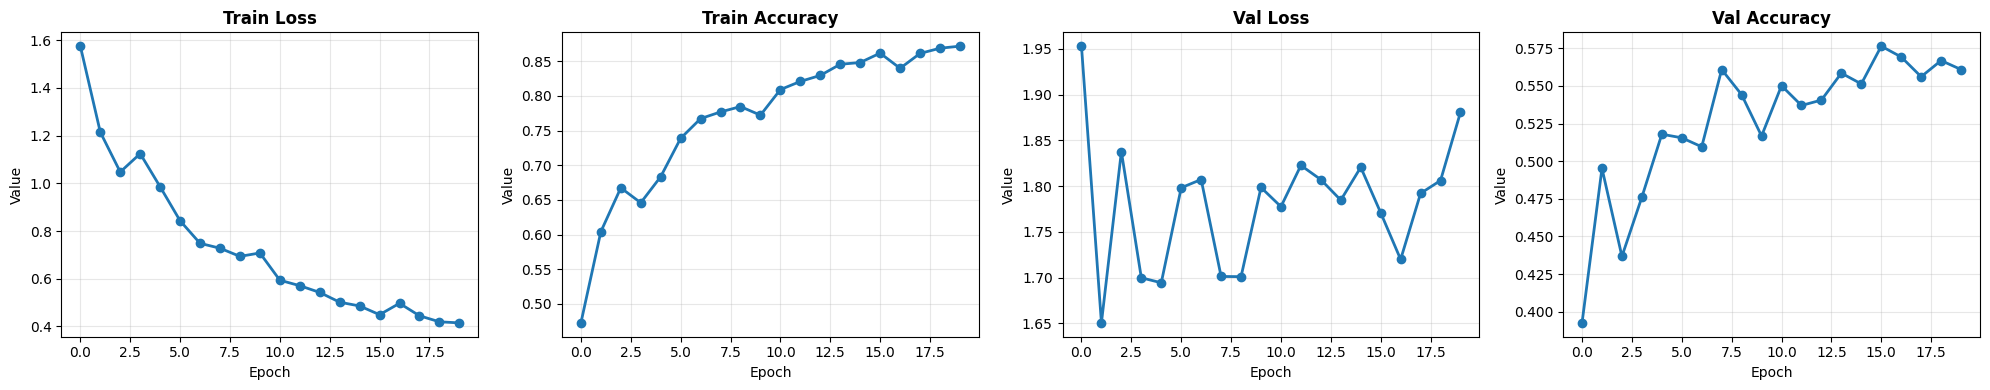

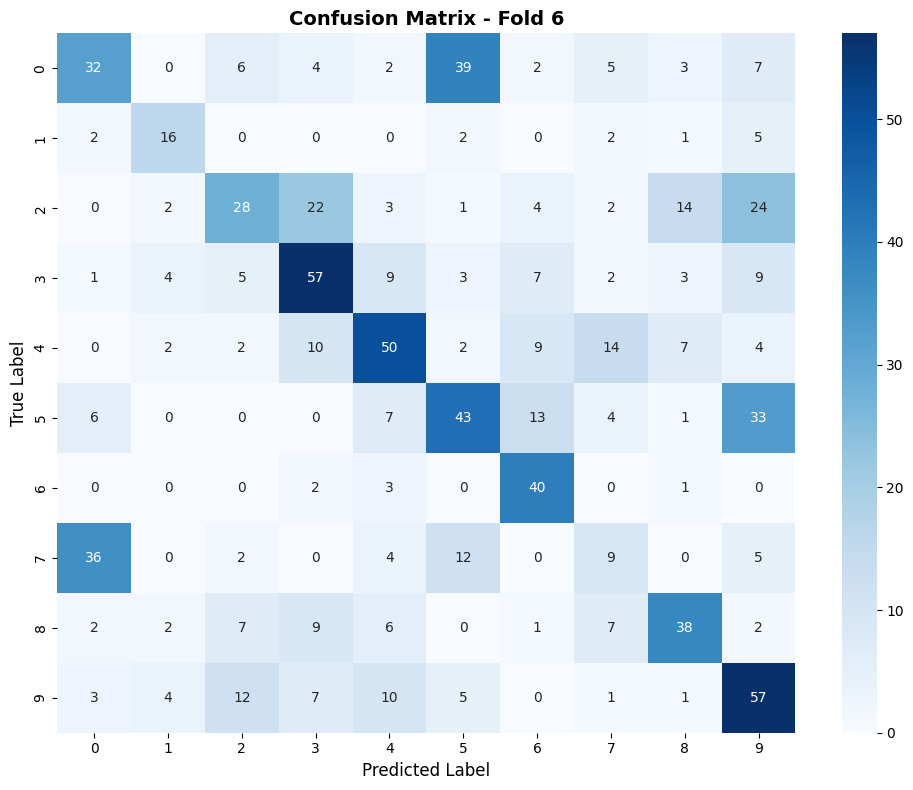


Fold 6 completed!
Results saved to: ../saved_cv/1130_003048/fold_6

FOLD 7/10
Test fold: 7
Validation fold: 8
Training folds: [1, 2, 3, 4, 5, 6, 9, 10]

STEP 1: Loading Data from Cache

STEP 2: Creating Model
Total parameters: 83,722
GPU memory after model creation: 39.54 MB

STEP 3: Training Model

Epoch 1/20
----------------------------------------


Train Loss: 1.5965, Train Acc: 0.4589
Val Loss: 1.9334, Val Acc: 0.3908

Epoch 2/20
----------------------------------------


Train Loss: 1.2167, Train Acc: 0.6108
Val Loss: 1.6758, Val Acc: 0.5149

Epoch 3/20
----------------------------------------


Train Loss: 1.1099, Train Acc: 0.6503
Val Loss: 1.9095, Val Acc: 0.4653

Epoch 4/20
----------------------------------------


Train Loss: 1.1604, Train Acc: 0.6220
Val Loss: 1.7905, Val Acc: 0.4615

Epoch 5/20
----------------------------------------


Train Loss: 1.1648, Train Acc: 0.6192
Val Loss: 2.1556, Val Acc: 0.4603

Epoch 6/20
----------------------------------------


Train Loss: 1.0230, Train Acc: 0.6757
Val Loss: 2.0243, Val Acc: 0.4504

Epoch 7/20
----------------------------------------


Train Loss: 1.0226, Train Acc: 0.6741
Val Loss: 2.0412, Val Acc: 0.4231

Epoch 8/20
----------------------------------------


Train Loss: 0.9908, Train Acc: 0.6808
Val Loss: 2.0143, Val Acc: 0.4739

Epoch 9/20
----------------------------------------


Train Loss: 0.9118, Train Acc: 0.7146
Val Loss: 2.1091, Val Acc: 0.4702

Epoch 10/20
----------------------------------------


Train Loss: 0.8504, Train Acc: 0.7350
Val Loss: 2.0073, Val Acc: 0.5050

Epoch 11/20
----------------------------------------


Train Loss: 0.7925, Train Acc: 0.7551
Val Loss: 2.0406, Val Acc: 0.4913

Epoch 12/20
----------------------------------------


Train Loss: 0.7627, Train Acc: 0.7643
Val Loss: 2.1487, Val Acc: 0.5074

Epoch 13/20
----------------------------------------


Train Loss: 0.7373, Train Acc: 0.7694
Val Loss: 2.0410, Val Acc: 0.5087

Epoch 14/20
----------------------------------------


Train Loss: 0.7038, Train Acc: 0.7788
Val Loss: 2.1413, Val Acc: 0.4864

Epoch 15/20
----------------------------------------


Train Loss: 0.7291, Train Acc: 0.7752
Val Loss: 2.1284, Val Acc: 0.4975

Epoch 16/20
----------------------------------------


Train Loss: 0.6726, Train Acc: 0.7911
Val Loss: 2.1901, Val Acc: 0.5186

Epoch 17/20
----------------------------------------


Train Loss: 0.6420, Train Acc: 0.8030
Val Loss: 2.2490, Val Acc: 0.5174

Epoch 18/20
----------------------------------------


Train Loss: 0.6235, Train Acc: 0.8086
Val Loss: 2.2323, Val Acc: 0.5112

Epoch 19/20
----------------------------------------


Train Loss: 0.6179, Train Acc: 0.8085
Val Loss: 2.1909, Val Acc: 0.5149

Epoch 20/20
----------------------------------------


Train Loss: 0.5875, Train Acc: 0.8200
Val Loss: 2.2810, Val Acc: 0.5186

STEP 4: Testing on Held-Out Fold


Testing: 100%|██████████| 53/53 [00:00<00:00, 129.75it/s, loss=0.9251]



Test Loss: 1.7767
Test Accuracy: 0.4893

Test Metrics:
  Accuracy:          0.4893
  Precision (macro): 0.5148
  Recall (macro):    0.5243
  F1-Score (macro):  0.4887
  Precision (wtd):   0.5203
  Recall (wtd):      0.4893
  F1-Score (wtd):    0.4810


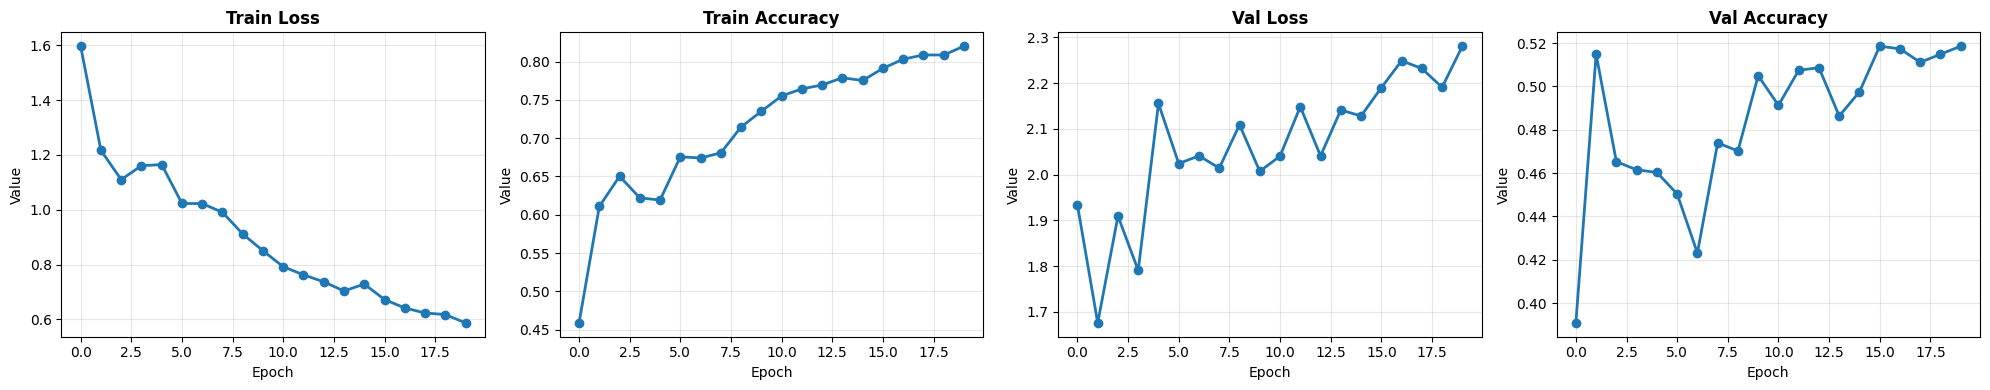

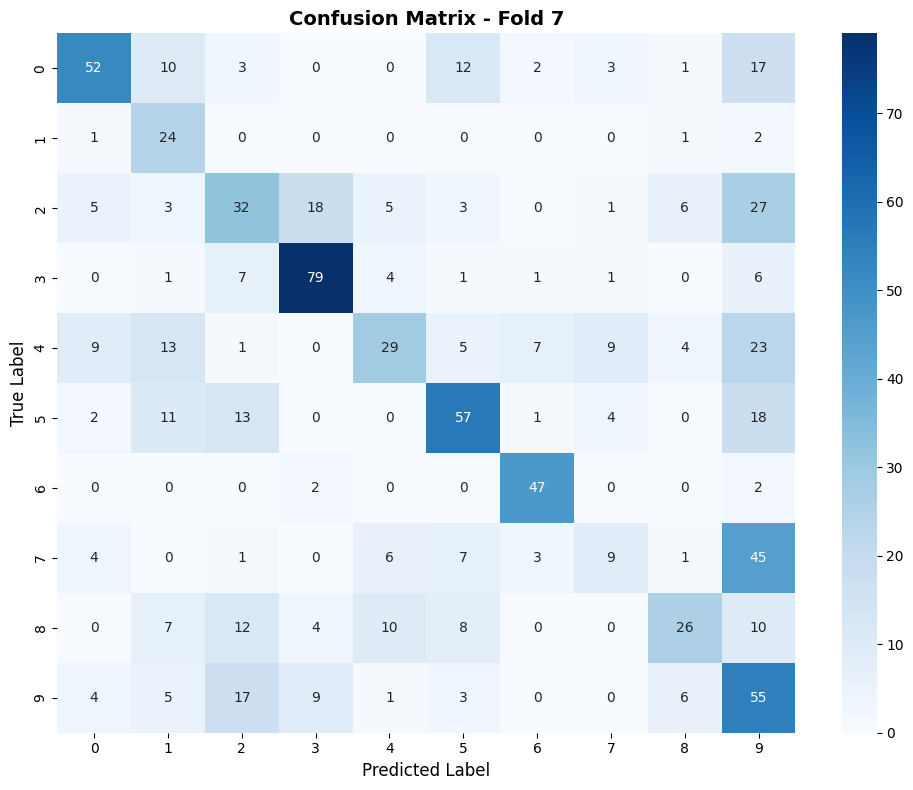


Fold 7 completed!
Results saved to: ../saved_cv/1130_003048/fold_7

FOLD 8/10
Test fold: 8
Validation fold: 9
Training folds: [1, 2, 3, 4, 5, 6, 7, 10]

STEP 1: Loading Data from Cache

STEP 2: Creating Model
Total parameters: 83,722
GPU memory after model creation: 39.54 MB

STEP 3: Training Model

Epoch 1/20
----------------------------------------


Train Loss: 1.6037, Train Acc: 0.4639
Val Loss: 1.9038, Val Acc: 0.4387

Epoch 2/20
----------------------------------------


Train Loss: 1.1706, Train Acc: 0.6265
Val Loss: 1.5459, Val Acc: 0.5858

Epoch 3/20
----------------------------------------


Train Loss: 0.9922, Train Acc: 0.6832
Val Loss: 1.7719, Val Acc: 0.5527

Epoch 4/20
----------------------------------------


Train Loss: 0.8761, Train Acc: 0.7289
Val Loss: 2.1361, Val Acc: 0.4755

Epoch 5/20
----------------------------------------


Train Loss: 1.0253, Train Acc: 0.6770
Val Loss: 1.6461, Val Acc: 0.5502

Epoch 6/20
----------------------------------------


Train Loss: 0.7712, Train Acc: 0.7618
Val Loss: 1.6229, Val Acc: 0.5784

Epoch 7/20
----------------------------------------


Train Loss: 0.7100, Train Acc: 0.7765
Val Loss: 1.6077, Val Acc: 0.5993

Epoch 8/20
----------------------------------------


Train Loss: 0.6528, Train Acc: 0.7926
Val Loss: 1.7044, Val Acc: 0.5895

Epoch 9/20
----------------------------------------


Train Loss: 0.6172, Train Acc: 0.8078
Val Loss: 1.8671, Val Acc: 0.5699

Epoch 10/20
----------------------------------------


Train Loss: 0.5844, Train Acc: 0.8144
Val Loss: 1.8243, Val Acc: 0.5944

Epoch 11/20
----------------------------------------


Train Loss: 0.5037, Train Acc: 0.8413
Val Loss: 1.9144, Val Acc: 0.6005

Epoch 12/20
----------------------------------------


Train Loss: 0.4620, Train Acc: 0.8571
Val Loss: 1.9102, Val Acc: 0.6066

Epoch 13/20
----------------------------------------


Train Loss: 0.4634, Train Acc: 0.8527
Val Loss: 1.9917, Val Acc: 0.5895

Epoch 14/20
----------------------------------------


Train Loss: 0.4412, Train Acc: 0.8606
Val Loss: 1.9176, Val Acc: 0.5980

Epoch 15/20
----------------------------------------


Train Loss: 0.4382, Train Acc: 0.8613
Val Loss: 2.2665, Val Acc: 0.5760

Epoch 16/20
----------------------------------------


Train Loss: 0.3883, Train Acc: 0.8825
Val Loss: 2.0342, Val Acc: 0.6250

Epoch 17/20
----------------------------------------


Train Loss: 0.3542, Train Acc: 0.8903
Val Loss: 2.1200, Val Acc: 0.6005

Epoch 18/20
----------------------------------------


Train Loss: 0.3407, Train Acc: 0.8970
Val Loss: 2.2559, Val Acc: 0.5784

Epoch 19/20
----------------------------------------


Train Loss: 0.3334, Train Acc: 0.8985
Val Loss: 2.0975, Val Acc: 0.6054

Epoch 20/20
----------------------------------------


Train Loss: 0.3149, Train Acc: 0.9036
Val Loss: 2.1370, Val Acc: 0.6201

STEP 4: Testing on Held-Out Fold


Testing: 100%|██████████| 51/51 [00:00<00:00, 85.31it/s, loss=0.7956]



Test Loss: 1.6151
Test Accuracy: 0.5645

Test Metrics:
  Accuracy:          0.5645
  Precision (macro): 0.5922
  Recall (macro):    0.6155
  F1-Score (macro):  0.5857
  Precision (wtd):   0.5766
  Recall (wtd):      0.5645
  F1-Score (wtd):    0.5571


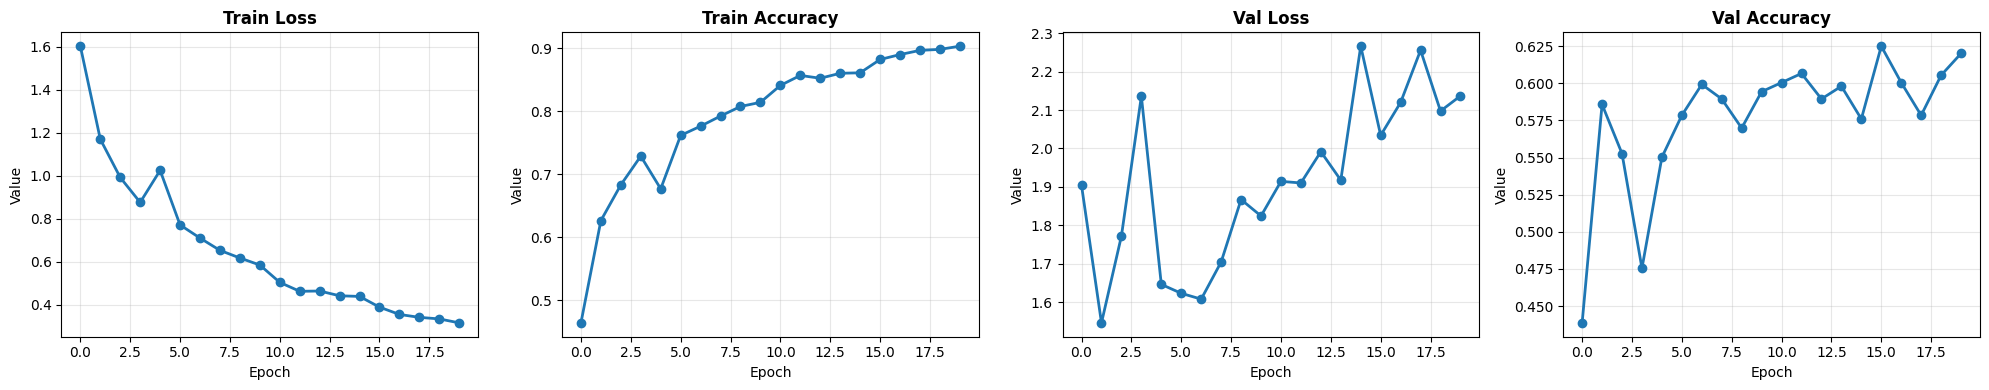

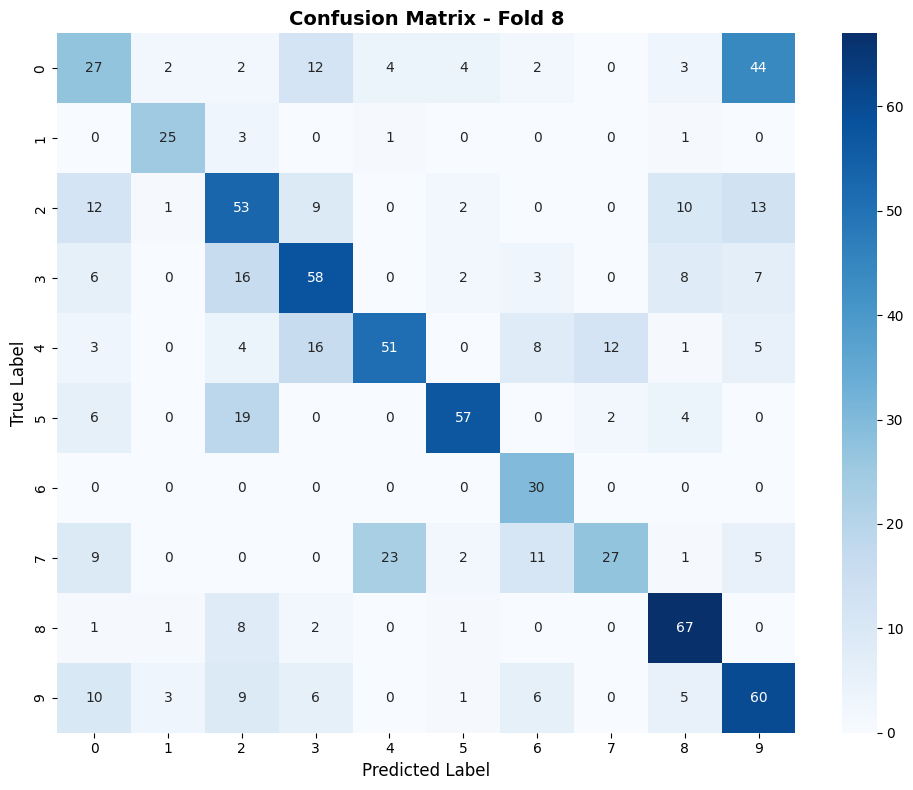


Fold 8 completed!
Results saved to: ../saved_cv/1130_003048/fold_8

FOLD 9/10
Test fold: 9
Validation fold: 10
Training folds: [1, 2, 3, 4, 5, 6, 7, 8]

STEP 1: Loading Data from Cache

STEP 2: Creating Model
Total parameters: 83,722
GPU memory after model creation: 39.54 MB

STEP 3: Training Model

Epoch 1/20
----------------------------------------


Train Loss: 1.5890, Train Acc: 0.4621
Val Loss: 1.7654, Val Acc: 0.4516

Epoch 2/20
----------------------------------------


Train Loss: 1.1794, Train Acc: 0.6228
Val Loss: 1.6804, Val Acc: 0.4313

Epoch 3/20
----------------------------------------


Train Loss: 0.9837, Train Acc: 0.6907
Val Loss: 1.8000, Val Acc: 0.4898

Epoch 4/20
----------------------------------------


Train Loss: 0.9197, Train Acc: 0.7094
Val Loss: 1.8635, Val Acc: 0.4839

Epoch 5/20
----------------------------------------


Train Loss: 0.8463, Train Acc: 0.7334
Val Loss: 1.7952, Val Acc: 0.4863

Epoch 6/20
----------------------------------------


Train Loss: 0.7315, Train Acc: 0.7724
Val Loss: 2.0120, Val Acc: 0.4970

Epoch 7/20
----------------------------------------


Train Loss: 0.6410, Train Acc: 0.7970
Val Loss: 1.8390, Val Acc: 0.5317

Epoch 8/20
----------------------------------------


Train Loss: 0.6733, Train Acc: 0.7885
Val Loss: 1.9140, Val Acc: 0.4886

Epoch 9/20
----------------------------------------


Train Loss: 0.6244, Train Acc: 0.8045
Val Loss: 1.8873, Val Acc: 0.5436

Epoch 10/20
----------------------------------------


Train Loss: 0.5836, Train Acc: 0.8191
Val Loss: 2.0261, Val Acc: 0.5078

Epoch 11/20
----------------------------------------


Train Loss: 0.5360, Train Acc: 0.8335
Val Loss: 2.0327, Val Acc: 0.5257

Epoch 12/20
----------------------------------------


Train Loss: 0.4889, Train Acc: 0.8424
Val Loss: 2.0053, Val Acc: 0.5520

Epoch 13/20
----------------------------------------


Train Loss: 0.4560, Train Acc: 0.8502
Val Loss: 2.0713, Val Acc: 0.5376

Epoch 14/20
----------------------------------------


Train Loss: 0.4460, Train Acc: 0.8579
Val Loss: 2.0249, Val Acc: 0.5269

Epoch 15/20
----------------------------------------


Train Loss: 0.4271, Train Acc: 0.8609
Val Loss: 2.0757, Val Acc: 0.5472

Epoch 16/20
----------------------------------------


Train Loss: 0.3865, Train Acc: 0.8824
Val Loss: 2.0870, Val Acc: 0.5568

Epoch 17/20
----------------------------------------


Train Loss: 0.3890, Train Acc: 0.8807
Val Loss: 2.1372, Val Acc: 0.5388

Epoch 18/20
----------------------------------------


Train Loss: 0.3600, Train Acc: 0.8864
Val Loss: 2.2711, Val Acc: 0.5257

Epoch 19/20
----------------------------------------


Train Loss: 0.3524, Train Acc: 0.8891
Val Loss: 2.3065, Val Acc: 0.5245

Epoch 20/20
----------------------------------------


Train Loss: 0.3537, Train Acc: 0.8858
Val Loss: 2.2410, Val Acc: 0.5436

STEP 4: Testing on Held-Out Fold


Testing: 100%|██████████| 51/51 [00:00<00:00, 114.22it/s, loss=2.2587]



Test Loss: 1.8843
Test Accuracy: 0.4657

Test Metrics:
  Accuracy:          0.4657
  Precision (macro): 0.5059
  Recall (macro):    0.5070
  F1-Score (macro):  0.4876
  Precision (wtd):   0.4761
  Recall (wtd):      0.4657
  F1-Score (wtd):    0.4497


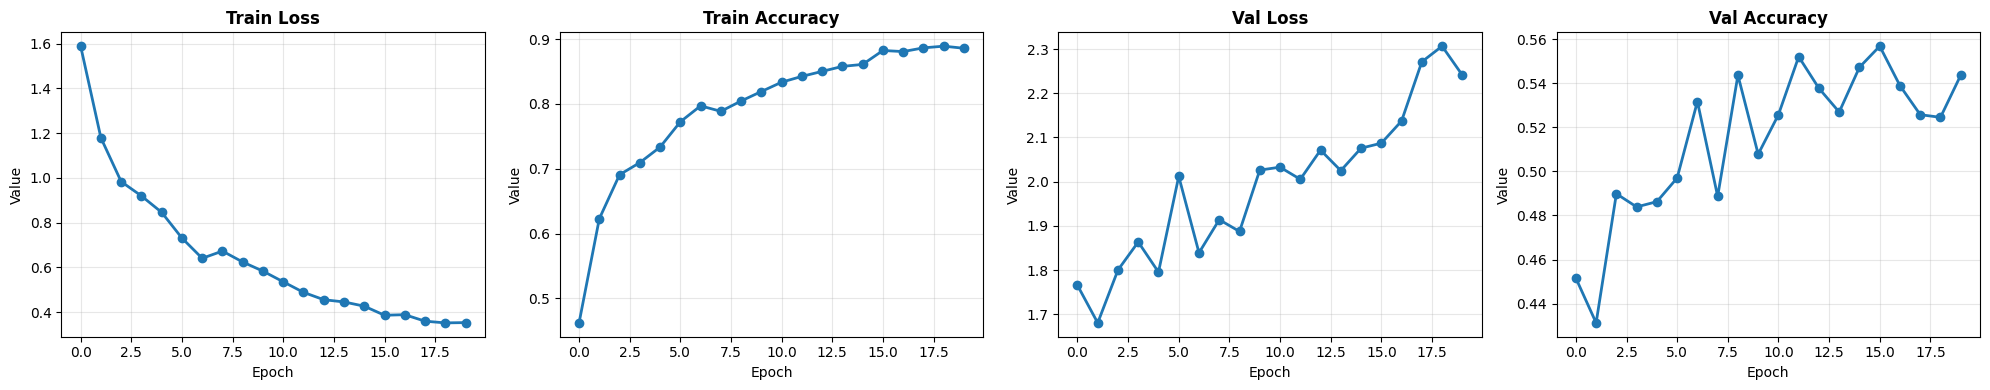

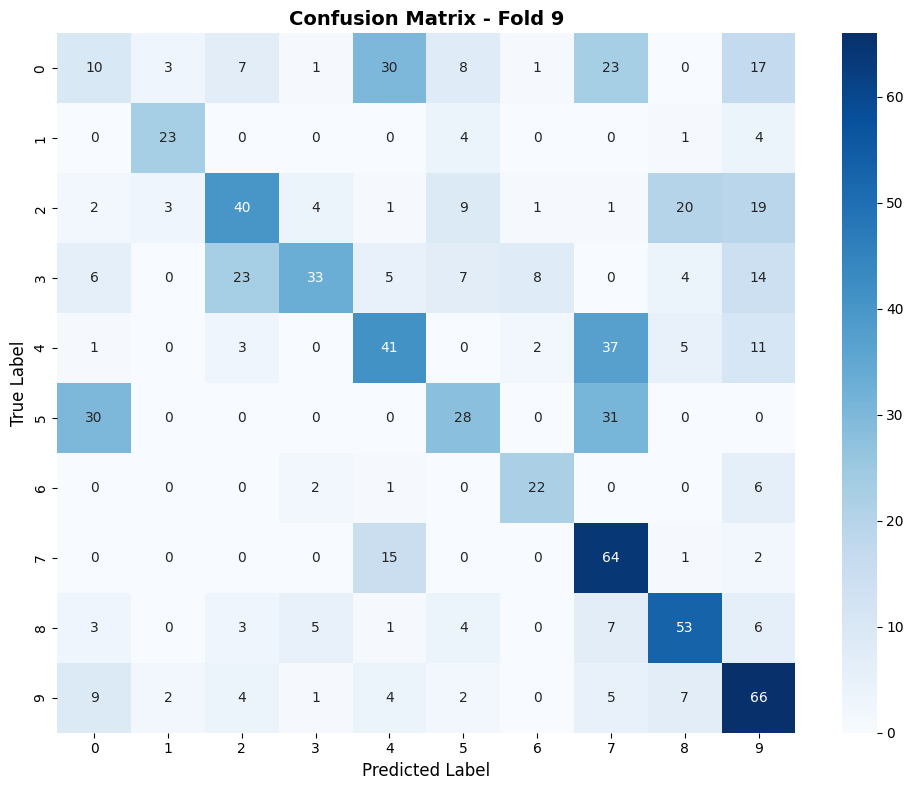


Fold 9 completed!
Results saved to: ../saved_cv/1130_003048/fold_9

FOLD 10/10
Test fold: 10
Validation fold: 1
Training folds: [2, 3, 4, 5, 6, 7, 8, 9]

STEP 1: Loading Data from Cache

STEP 2: Creating Model
Total parameters: 83,722
GPU memory after model creation: 39.54 MB

STEP 3: Training Model

Epoch 1/20
----------------------------------------


Train Loss: 1.5882, Train Acc: 0.4669
Val Loss: 1.9921, Val Acc: 0.3711

Epoch 2/20
----------------------------------------


Train Loss: 1.1752, Train Acc: 0.6206
Val Loss: 1.9302, Val Acc: 0.3803

Epoch 3/20
----------------------------------------


Train Loss: 1.0701, Train Acc: 0.6589
Val Loss: 2.0961, Val Acc: 0.3872

Epoch 4/20
----------------------------------------


Train Loss: 1.0156, Train Acc: 0.6752
Val Loss: 2.1047, Val Acc: 0.4112

Epoch 5/20
----------------------------------------


Train Loss: 0.8766, Train Acc: 0.7230
Val Loss: 2.0706, Val Acc: 0.4376

Epoch 6/20
----------------------------------------


Train Loss: 0.7214, Train Acc: 0.7798
Val Loss: 2.0771, Val Acc: 0.4593

Epoch 7/20
----------------------------------------


Train Loss: 0.6713, Train Acc: 0.7938
Val Loss: 2.4320, Val Acc: 0.4170

Epoch 8/20
----------------------------------------


Train Loss: 0.6370, Train Acc: 0.7988
Val Loss: 2.3889, Val Acc: 0.3814

Epoch 9/20
----------------------------------------


Train Loss: 0.6501, Train Acc: 0.7984
Val Loss: 2.2934, Val Acc: 0.4032

Epoch 10/20
----------------------------------------


Train Loss: 0.5944, Train Acc: 0.8226
Val Loss: 2.4563, Val Acc: 0.4170

Epoch 11/20
----------------------------------------


Train Loss: 0.5203, Train Acc: 0.8371
Val Loss: 2.4721, Val Acc: 0.4456

Epoch 12/20
----------------------------------------


Train Loss: 0.4906, Train Acc: 0.8481
Val Loss: 2.4750, Val Acc: 0.4170

Epoch 13/20
----------------------------------------


Train Loss: 0.4365, Train Acc: 0.8645
Val Loss: 2.4540, Val Acc: 0.4467

Epoch 14/20
----------------------------------------


Train Loss: 0.4400, Train Acc: 0.8597
Val Loss: 2.4886, Val Acc: 0.4147

Epoch 15/20
----------------------------------------


Train Loss: 0.4339, Train Acc: 0.8649
Val Loss: 2.4897, Val Acc: 0.4238

Epoch 16/20
----------------------------------------


Train Loss: 0.4013, Train Acc: 0.8760
Val Loss: 2.3312, Val Acc: 0.4525

Epoch 17/20
----------------------------------------


Train Loss: 0.3648, Train Acc: 0.8883
Val Loss: 2.4258, Val Acc: 0.4616

Epoch 18/20
----------------------------------------


Train Loss: 0.3571, Train Acc: 0.8909
Val Loss: 2.4837, Val Acc: 0.4559

Epoch 19/20
----------------------------------------


Train Loss: 0.3520, Train Acc: 0.8929
Val Loss: 2.5208, Val Acc: 0.4548

Epoch 20/20
----------------------------------------


Train Loss: 0.3437, Train Acc: 0.8965
Val Loss: 2.6922, Val Acc: 0.4479

STEP 4: Testing on Held-Out Fold


Testing: 100%|██████████| 53/53 [00:00<00:00, 90.37it/s, loss=2.6302]



Test Loss: 1.8429
Test Accuracy: 0.4659

Test Metrics:
  Accuracy:          0.4659
  Precision (macro): 0.4819
  Recall (macro):    0.5042
  F1-Score (macro):  0.4693
  Precision (wtd):   0.4758
  Recall (wtd):      0.4659
  F1-Score (wtd):    0.4500


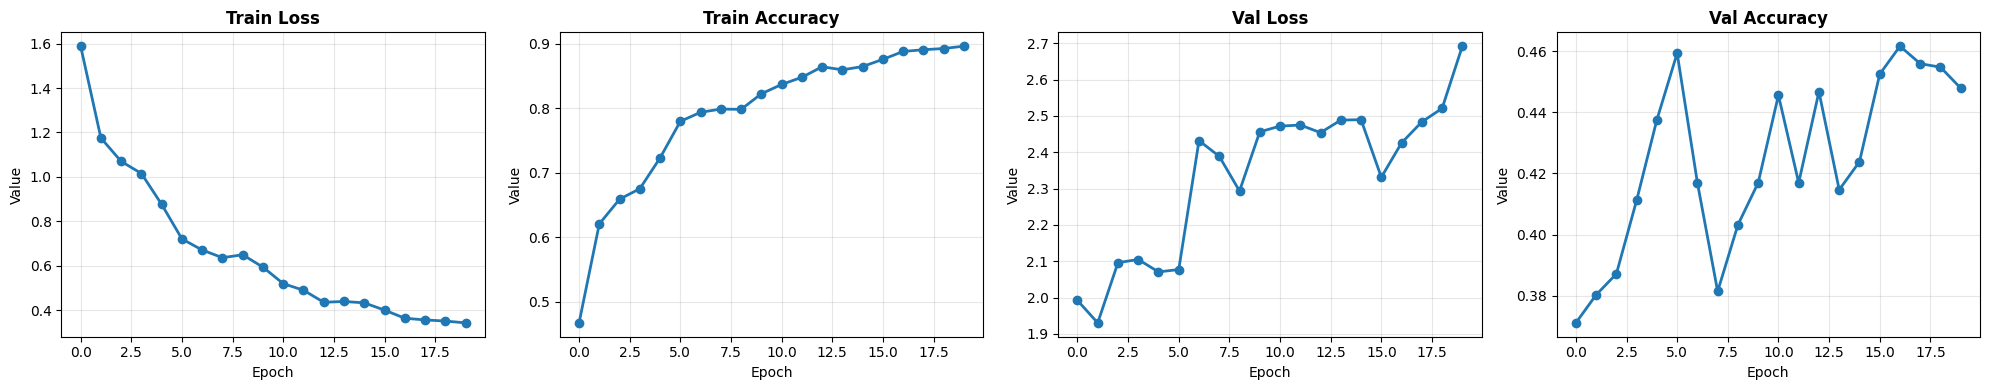

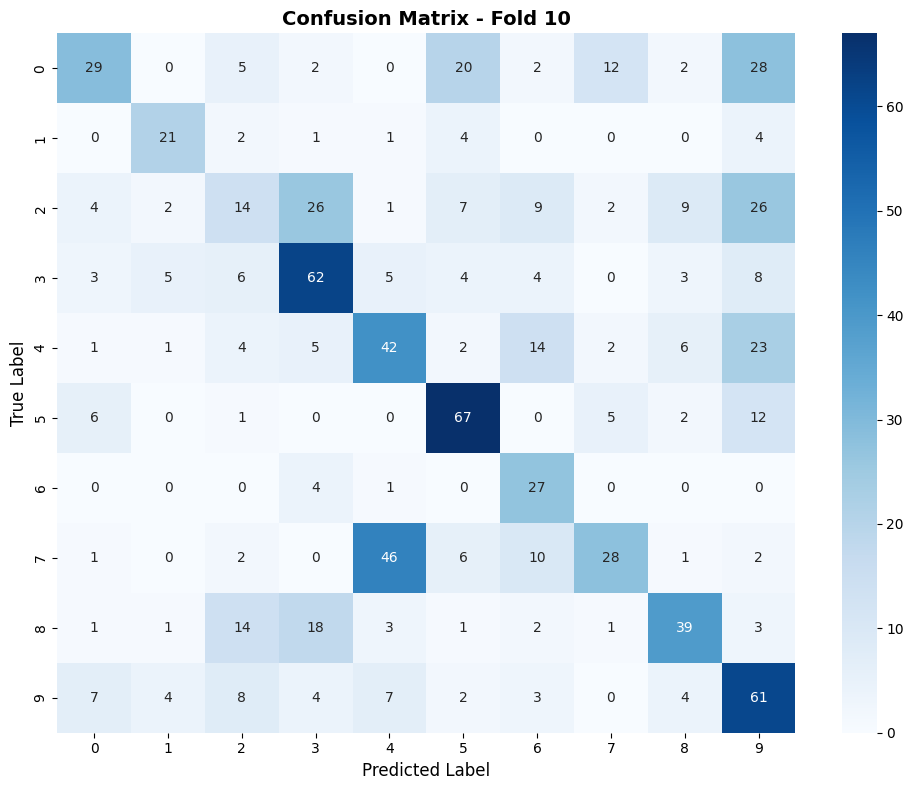


Fold 10 completed!
Results saved to: ../saved_cv/1130_003048/fold_10

CROSS-VALIDATION RESULTS

CROSS-VALIDATION RESULTS

Metrics per fold:
Fold   Acc      Prec(M)    Rec(M)     F1(M)     
--------------------------------------------------
1      0.4742   0.4974     0.5152     0.4930    
2      0.3705   0.4046     0.4244     0.3842    
3      0.3805   0.3865     0.4227     0.3821    
4      0.5263   0.5227     0.5353     0.5127    
5      0.5256   0.5163     0.5499     0.5217    
6      0.4496   0.4486     0.4729     0.4515    
7      0.4893   0.5148     0.5243     0.4887    
8      0.5645   0.5922     0.6155     0.5857    
9      0.4657   0.5059     0.5070     0.4876    
10     0.4659   0.4819     0.5042     0.4693    

AGGREGATE RESULTS (Mean ± Std)
Accuracy:              0.4712 ± 0.0582
Precision (macro):     0.4871 ± 0.0573
Recall (macro):        0.5071 ± 0.0546
F1-Score (macro):      0.4777 ± 0.0582
Precision (weighted):  0.4794 ± 0.0601
Recall (weighted):     0.4712 ± 0.0582
F1-

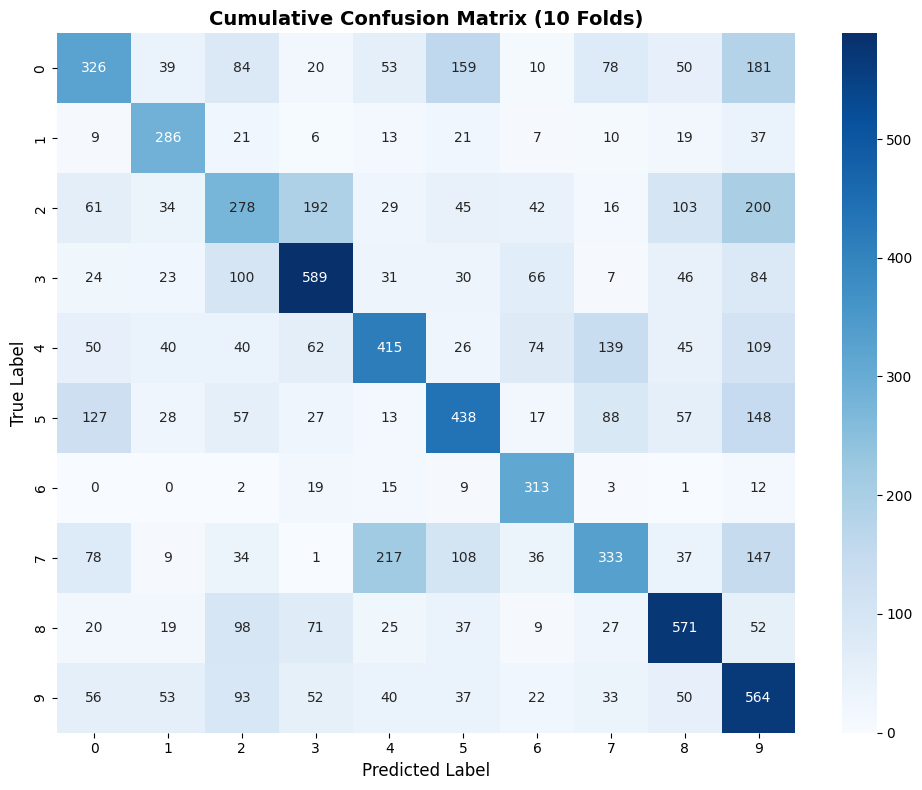

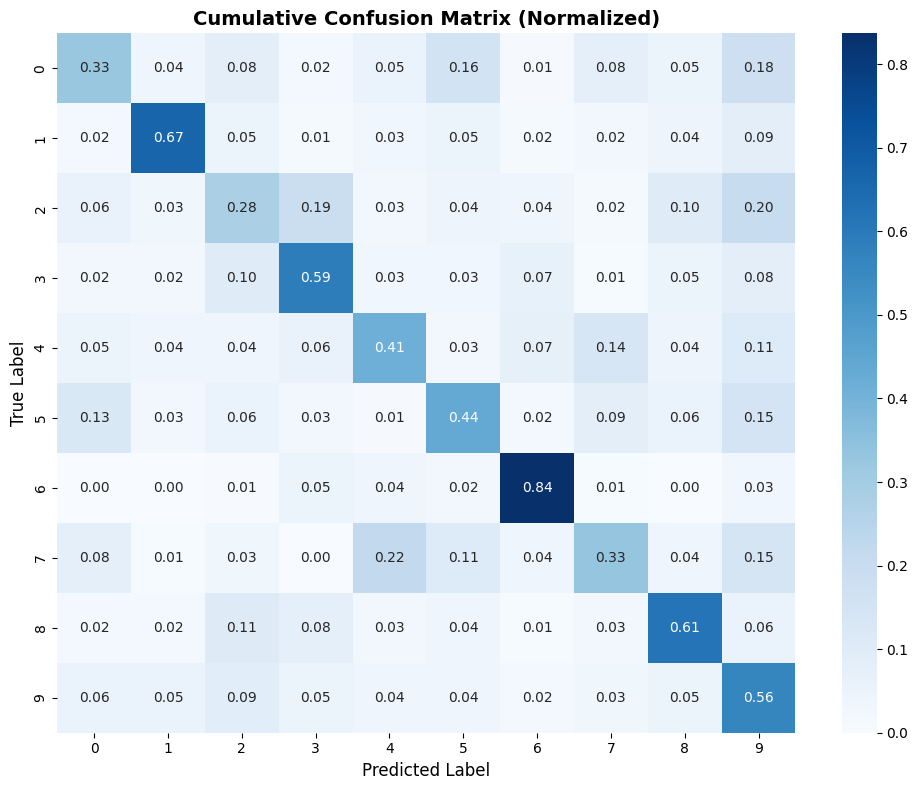

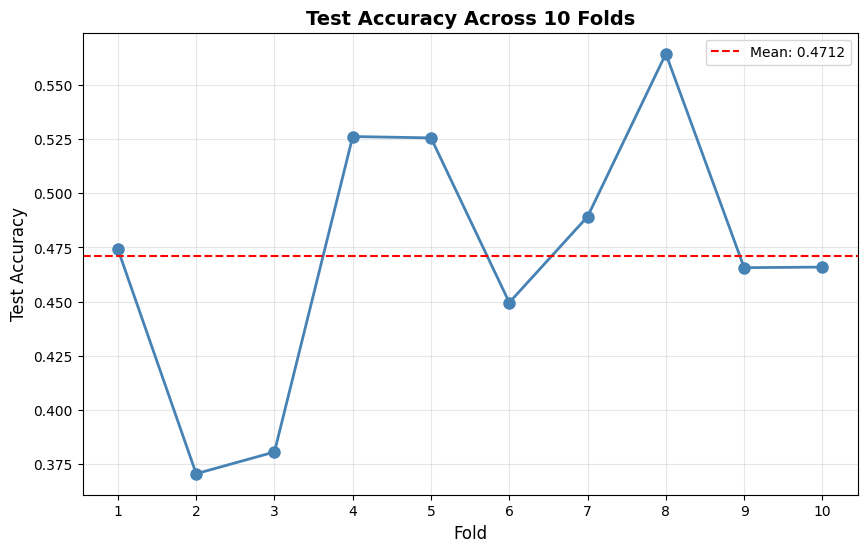

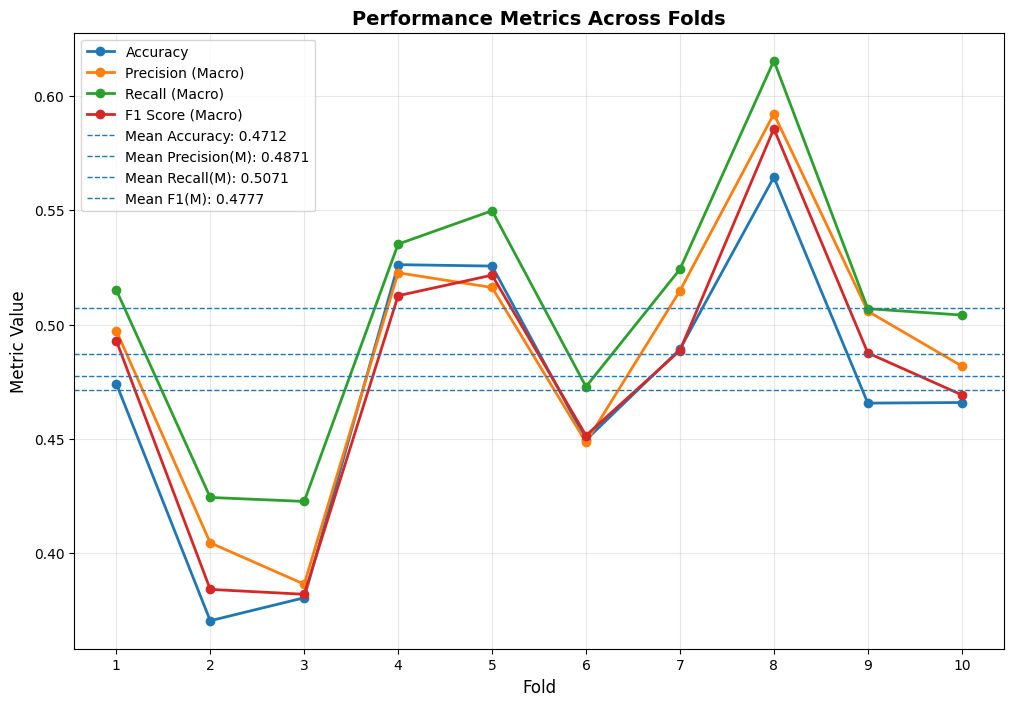


All results saved to: ../saved_cv/1130_003048
Model saved to: ../saved_cv/1130_003048


In [11]:
results = train_audio_rnn_cross_validation(data_cache_dir, config)
print(f"Model saved to: {results['save_dir']}")